# Ring broadcast experiment

In this experiment, N ranks perform a ring broadcast. We measure the duration of the individual calls to `MPI_Recv` and `MPI_Send`.

In [1]:
import io
import os
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
import sys
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)), Loader=yaml.BaseLoader)

def load_ringrong(zip_name):
    df = read_csv(zip_name, 'result.csv').reset_index()
    df['msg_size'] = df['size']
    df.drop('size', inplace=True, axis=1)
    df['sub_id'] = df['index'] // 2 # identifying the MPI_Send and MPI_Recv that are part of a same ping-pong
    df['op_kind'] = df['sub_id'] % 2 # each rank makes two distincts ping-pong: one recv-send with the previous rank and one send-recv with the next rank
    df.loc[df['op_kind'] == 0, 'op_kind'] = 'recv-send'
    df.loc[df['op_kind'] == 1, 'op_kind'] = 'send-recv'
    remote_next = {31, 63}
    remote_prev = {0, 32}
    df.loc[df['rank'].isin(remote_prev) & (df['op_kind'] == 'recv-send'), 'experiment'] = 'remote'
    df.loc[~df['rank'].isin(remote_prev) & (df['op_kind'] == 'recv-send'), 'experiment'] = 'loopback'
    df.loc[df['rank'].isin(remote_next) & (df['op_kind'] == 'send-recv'), 'experiment'] = 'remote'
    df.loc[~df['rank'].isin(remote_next) & (df['op_kind'] == 'send-recv'), 'experiment'] = 'loopback'
    df_send = df[df['function'] == 'MPI_Send']
    df_recv = df[df['function'] == 'MPI_Recv']
    df_ringrong = df_send.set_index(['rank', 'op_id', 'sub_id', 'op_kind', 'experiment', 'msg_size']).join(df_recv.set_index(['rank', 'op_id', 'sub_id', 'op_kind', 'experiment', 'msg_size']), lsuffix='_send', rsuffix='_recv').reset_index()
    df_ringrong['duration'] = df_ringrong['duration_send'] + df_ringrong['duration_recv']
    info = get_yaml(zip_name, 'info.yaml')
    install = get_yaml(zip_name, info['installfile'])
    for df in [df_send, df_recv, df_ringrong]:
        df['cluster'] = info['cluster']
        for key in ['matrix_size', 'perf_pct']:
            df[key] = int(install[key])
        for key in ['hyperthreading', 'turboboost', 'idle_state']:
            df[key] = install[key]
    return {
        'ringrong': df_ringrong,
        'send': df_send,
        'recv': df_recv
    }

In [2]:
directory = 'ring/6/'
archives = [os.path.join(directory, f) for f in os.listdir(directory)]
df = pandas.concat([load_ringrong(f)['recv'] for f in archives])
df['matrix_size'] = pandas.Categorical(df['matrix_size'], categories=df[['matrix_size']].drop_duplicates().sort_values(by='matrix_size')['matrix_size'], ordered=True)
df

,index,function,rank,op_id,timestamp,duration,msg_size,sub_id,op_kind,experiment,cluster,matrix_size,perf_pct,hyperthreading,turboboost,idle_state
1,1,MPI_Recv,0,0,0.189064,0.061304,268435456,0,recv-send,remote,dahu,128,50,false,false,false
2,2,MPI_Recv,0,0,13.883101,0.142513,268435456,1,send-recv,loopback,dahu,128,50,false,false,false
5,5,MPI_Recv,0,1,14.244489,0.067842,268435456,2,recv-send,remote,dahu,128,50,false,false,false
6,6,MPI_Recv,0,1,27.963528,0.153593,268435456,3,send-recv,loopback,dahu,128,50,false,false,false
9,9,MPI_Recv,0,2,28.337075,0.061164,268435456,4,recv-send,remote,dahu,128,50,false,false,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5111,5111,MPI_Recv,63,17,253.730945,0.063179,268435456,2555,send-recv,remote,dahu,128,100,false,false,false
5112,5112,MPI_Recv,63,18,267.432716,0.155370,268435456,2556,recv-send,loopback,dahu,128,100,false,false,false
5115,5115,MPI_Recv,63,18,267.799425,0.063075,268435456,2557,send-recv,remote,dahu,128,100,false,false,false
5116,5116,MPI_Recv,63,19,281.565293,0.152889,268435456,2558,recv-send,loopback,dahu,128,100,false,false,false


In [3]:
function = df['function'].unique()
assert len(function) == 1
function = function[0]
function

'MPI_Recv'

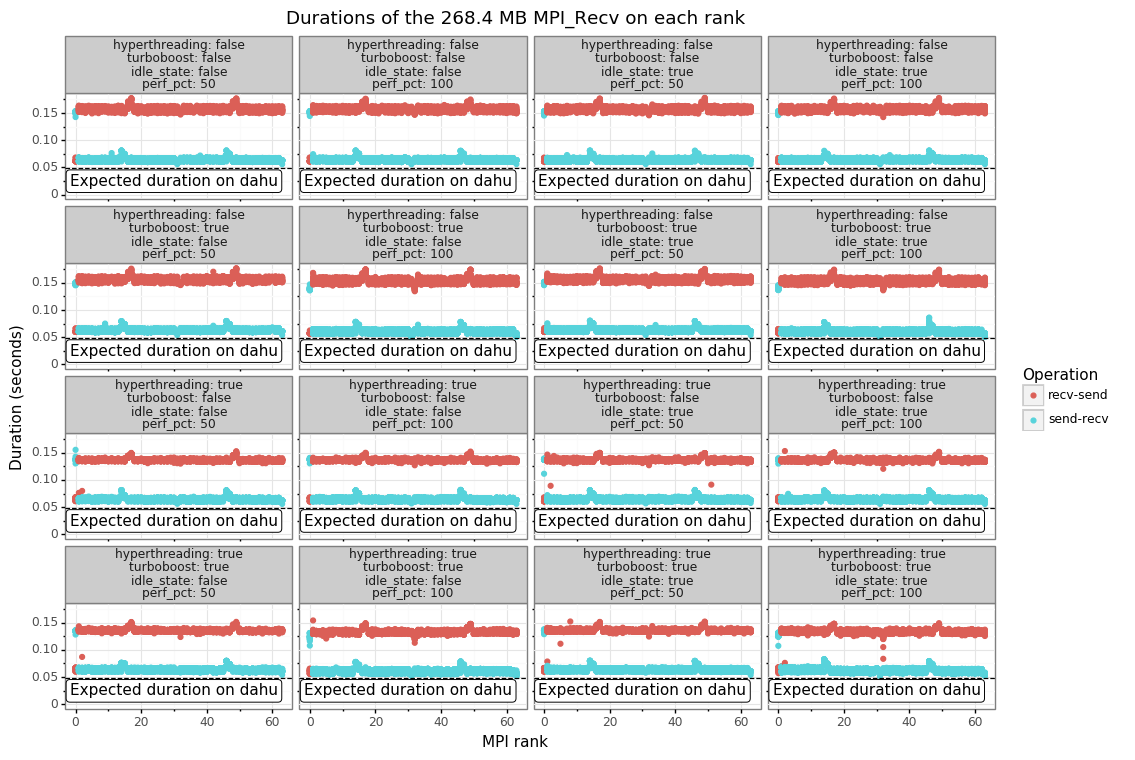

<ggplot: (-9223363305365789517)>

In [4]:
df['size'] = df['msg_size']
bw  = 25*1e9
lat = 0.1*1e-6
bw_factor = 0.219
lat_factor = 0
size = df['size'].max()
theoretical_duration = size/(bw*bw_factor) + lat*lat_factor

(ggplot(df[df['size'] == size])
    + aes(x='rank', y='duration', color='op_kind')
    + geom_point() 
    + theme_bw()
    + expand_limits(y=0)
    + geom_hline(yintercept=theoretical_duration, linetype='dashed')
    + facet_wrap(['hyperthreading', 'turboboost', 'idle_state', 'perf_pct'], labeller='label_both')
    + labs(x='MPI rank', y='Duration (seconds)', color='Operation')
    + annotate('label', x=30, y=theoretical_duration*0.5, label='Expected duration on dahu')
    + ggtitle(f'Durations of the {size*1e-6:.1f} MB {function} on each rank')
)

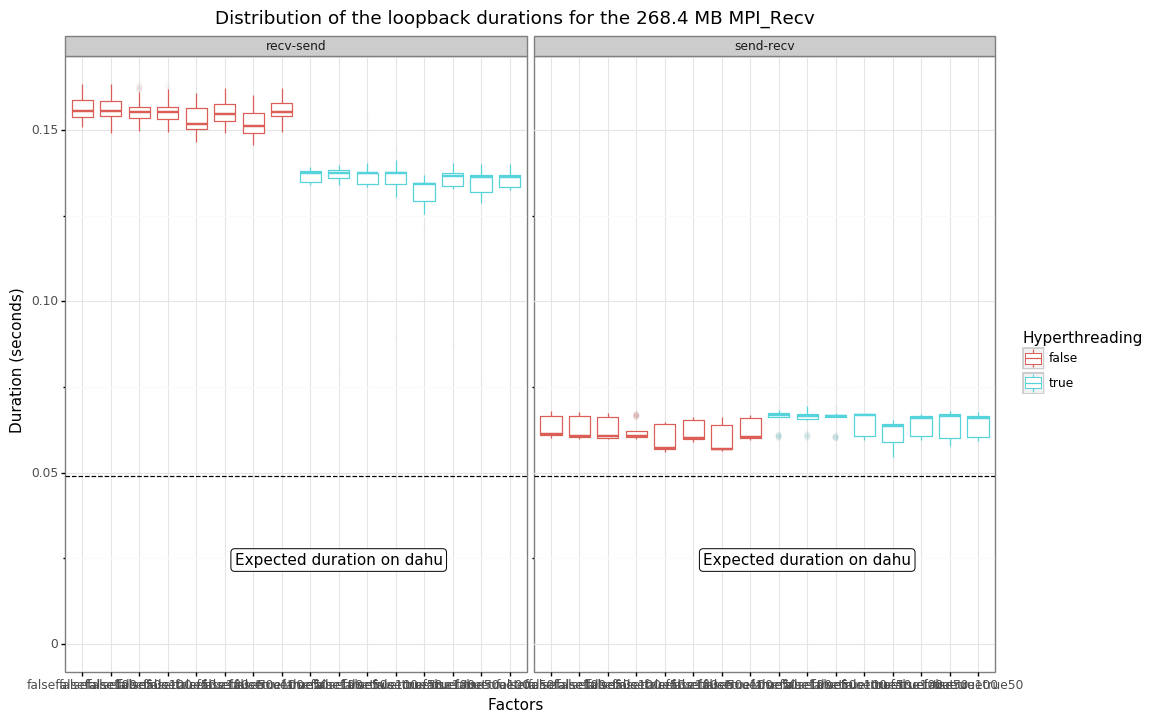

<ggplot: (8731485628385)>

In [5]:
df['x'] = df['hyperthreading'].astype(str) + df['turboboost'].astype(str) + df['idle_state'].astype(str) + df['perf_pct'].astype(str)
(ggplot(df[df['rank'].isin(range(2, 7)) & (df['size'] == size)])
        + aes(x='x', y='duration', color='hyperthreading')
        + geom_boxplot(outlier_alpha=0.01)
        + theme_bw()
        + geom_hline(yintercept=theoretical_duration, linetype='dashed')
        + annotate('label', x=10, y=theoretical_duration*0.5, label='Expected duration on dahu')
        + labs(x='Factors', y='Duration (seconds)', color='Hyperthreading')
        + facet_wrap('op_kind')
        + ggtitle(f'Distribution of the loopback durations for the {size*1e-6:.1f} MB {function}')
#        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
        + expand_limits(y=0)
)

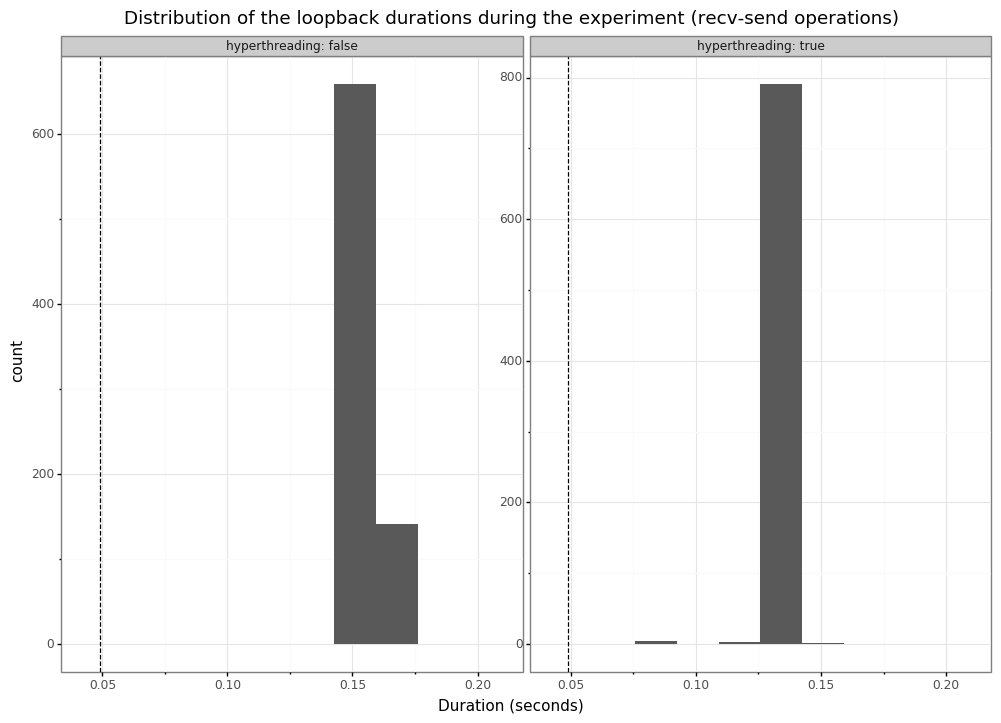

<ggplot: (8731489312874)>


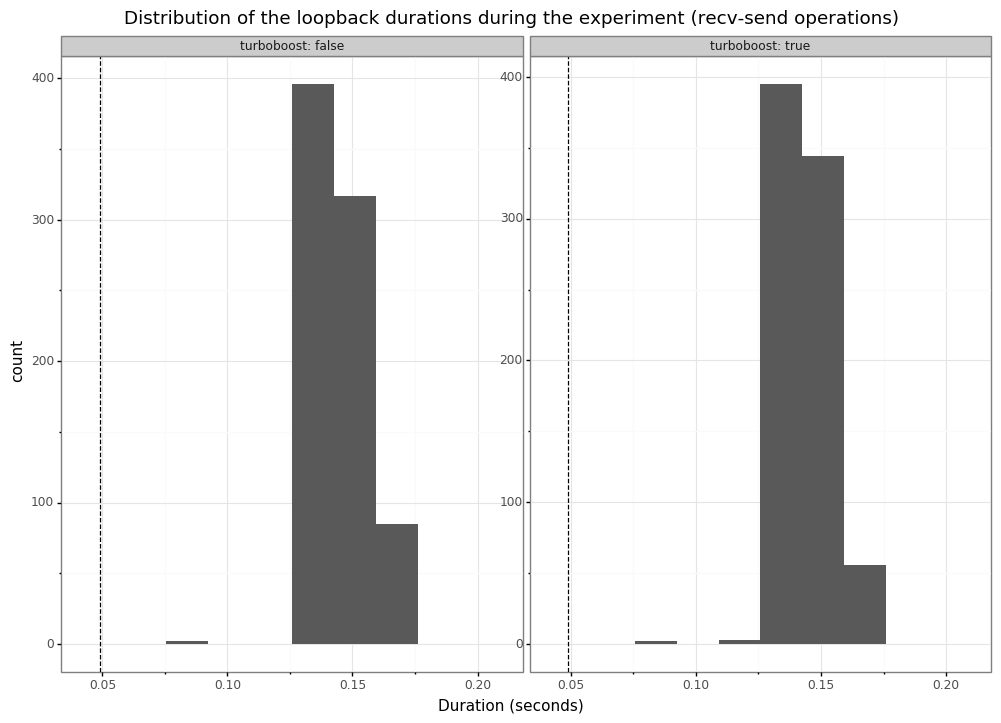

<ggplot: (8731485678207)>


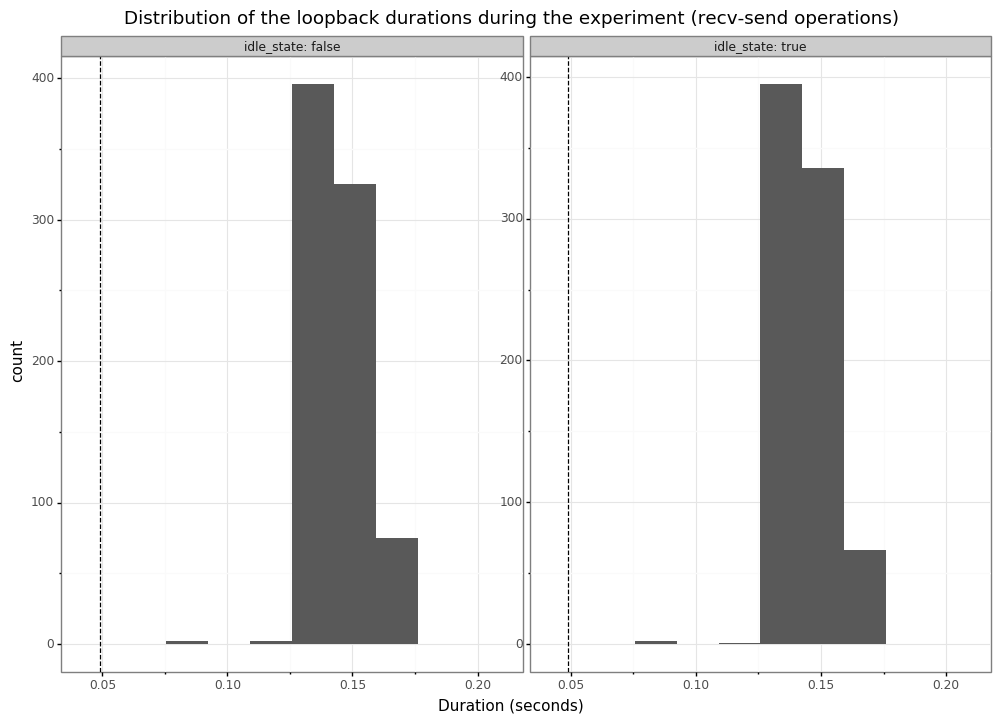

<ggplot: (-9223363305369352409)>


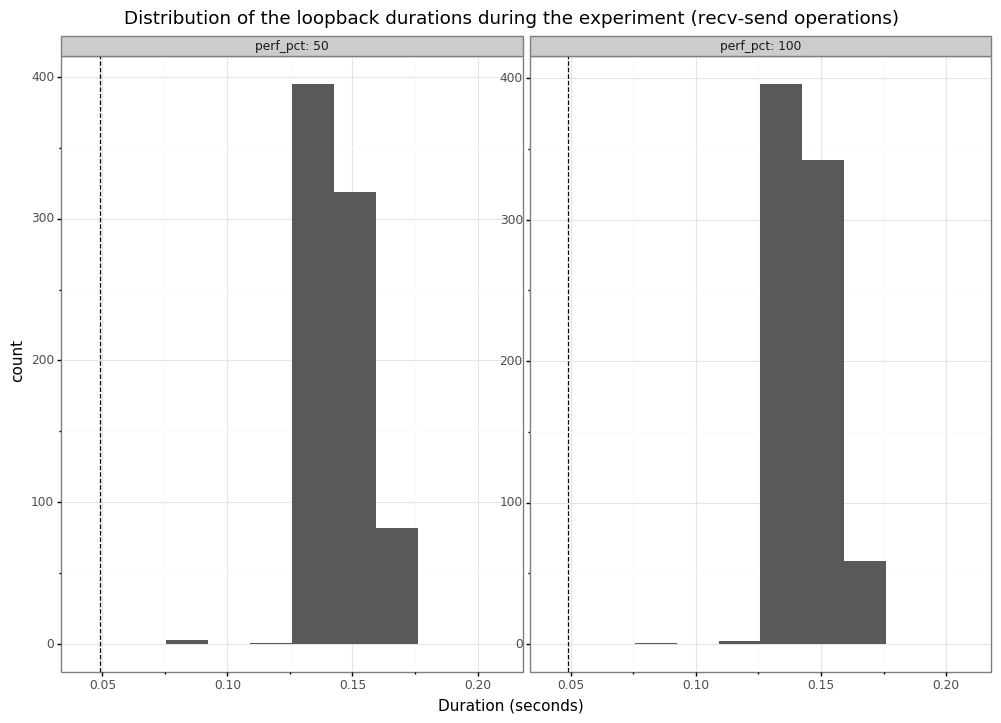

<ggplot: (8731488959899)>


In [6]:
tmp = df[df['rank'].isin(range(2, 7)) & (df['size'] == size) & (df['op_kind'] == 'recv-send')]
col = ['hyperthreading', 'turboboost', 'idle_state', 'perf_pct']
for c in col:
    print(ggplot(tmp)
            + aes(x='duration')
            + geom_histogram(bins=10)
            + theme_bw()
            + labs(x='Duration (seconds)')
            + ggtitle(f'Distribution of the loopback durations during the experiment (recv-send operations)')
            + facet_wrap(c, labeller='label_both', scales='free')
            + geom_vline(xintercept=theoretical_duration, linetype='dashed')
            + expand_limits(x=[0.05, 0.2])
    )

## Monitoring

In [7]:
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction

c0a430e3a498fc690b6244ca9909444040c28128


In [8]:
monitoring = []
for zip_name in archives:
    tmp = archive_extraction.read_monitoring(zip_name)
    info = get_yaml(zip_name, 'info.yaml')
    install = get_yaml(zip_name, info['installfile'])
    tmp['cluster'] = info['cluster']
    for key in ['matrix_size', 'perf_pct']:
        tmp[key] = int(install[key])
    for key in ['hyperthreading', 'turboboost', 'idle_state']:
        tmp[key] = install[key]
    monitoring.append(tmp)
monitoring = pandas.concat(monitoring)
monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
for date in monitoring['date'].unique():
    monitoring.loc[monitoring['date'] == date, 'real_start_time'] = monitoring[monitoring['date'] == date]['timestamp'].min()
monitoring['start_exp'] -= monitoring['real_start_time']
monitoring['stop_exp'] -= monitoring['real_start_time']
monitoring['timestamp'] -= monitoring['real_start_time']
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
monitoring['in_exp'] = (monitoring['timestamp'] > monitoring['start_exp'] + 60) & (monitoring['timestamp'] < monitoring['stop_exp'] - 60)
monitoring['hostname'] = monitoring['cluster'] + '-' + monitoring['node'].astype(str)
print(len(monitoring))
monitoring.head()

799680


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,...,matrix_size,perf_pct,hyperthreading,turboboost,idle_state,date,real_start_time,cpu_id,in_exp,hostname
0,0.000000,dahu,12,1946144,1598868602,d2d9a794d50065ef7faf81eb9860144d84b2be6b268dcb...,1.000140,0,0,frequency,...,128,50,false,false,false,2020-08-31 10:10:02,1.598876e+09,12:0,False,dahu-12
1,1.008773,dahu,12,1946144,1598868602,d2d9a794d50065ef7faf81eb9860144d84b2be6b268dcb...,2.902880,0,0,frequency,...,128,50,false,false,false,2020-08-31 10:10:02,1.598876e+09,12:0,False,dahu-12
2,2.017303,dahu,12,1946144,1598868602,d2d9a794d50065ef7faf81eb9860144d84b2be6b268dcb...,1.000012,0,0,frequency,...,128,50,false,false,false,2020-08-31 10:10:02,1.598876e+09,12:0,False,dahu-12
3,3.025664,dahu,12,1946144,1598868602,d2d9a794d50065ef7faf81eb9860144d84b2be6b268dcb...,1.000012,0,0,frequency,...,128,50,false,false,false,2020-08-31 10:10:02,1.598876e+09,12:0,False,dahu-12
4,4.033463,dahu,12,1946144,1598868602,d2d9a794d50065ef7faf81eb9860144d84b2be6b268dcb...,1.000012,0,0,frequency,...,128,50,false,false,false,2020-08-31 10:10:02,1.598876e+09,12:0,False,dahu-12


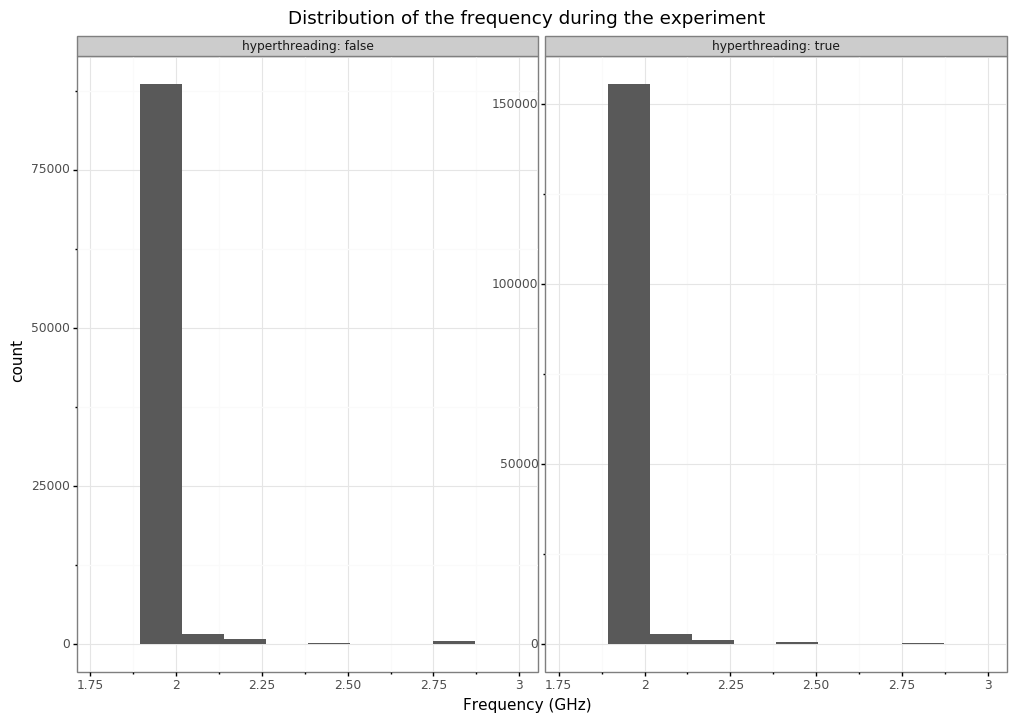

<ggplot: (-9223363305365948949)>


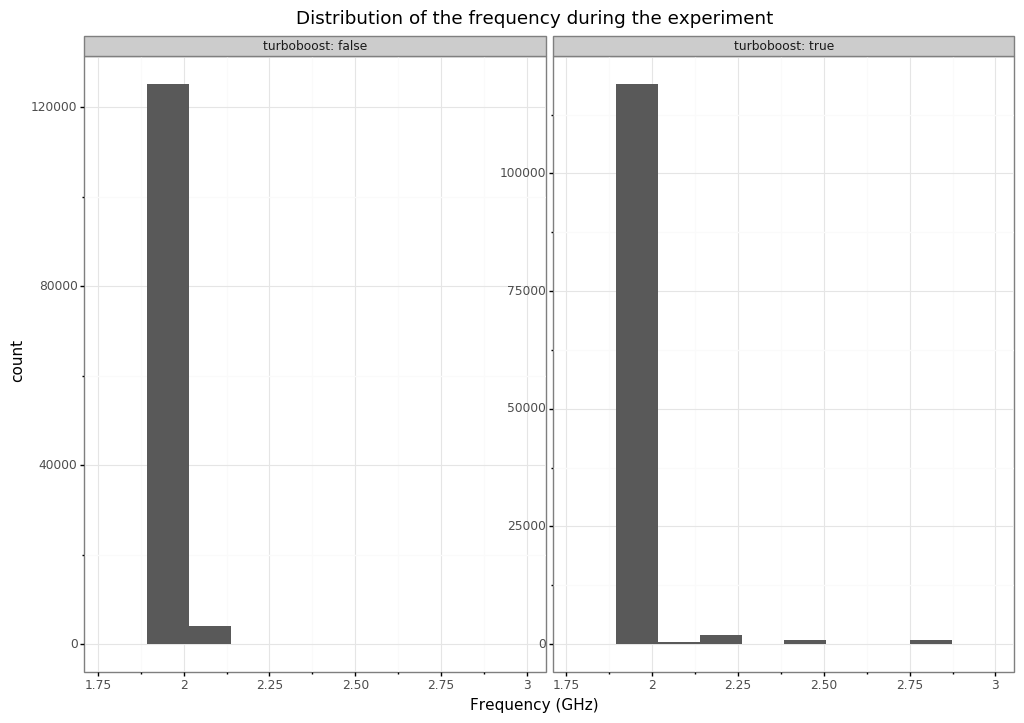

<ggplot: (8731486152347)>


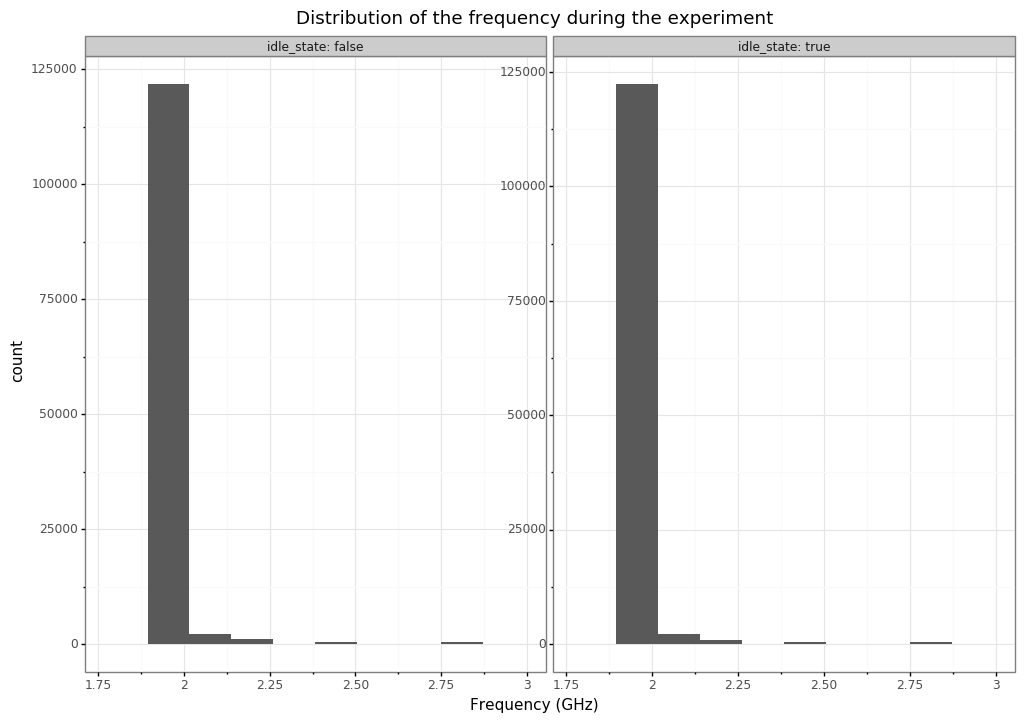

<ggplot: (-9223363305369342285)>


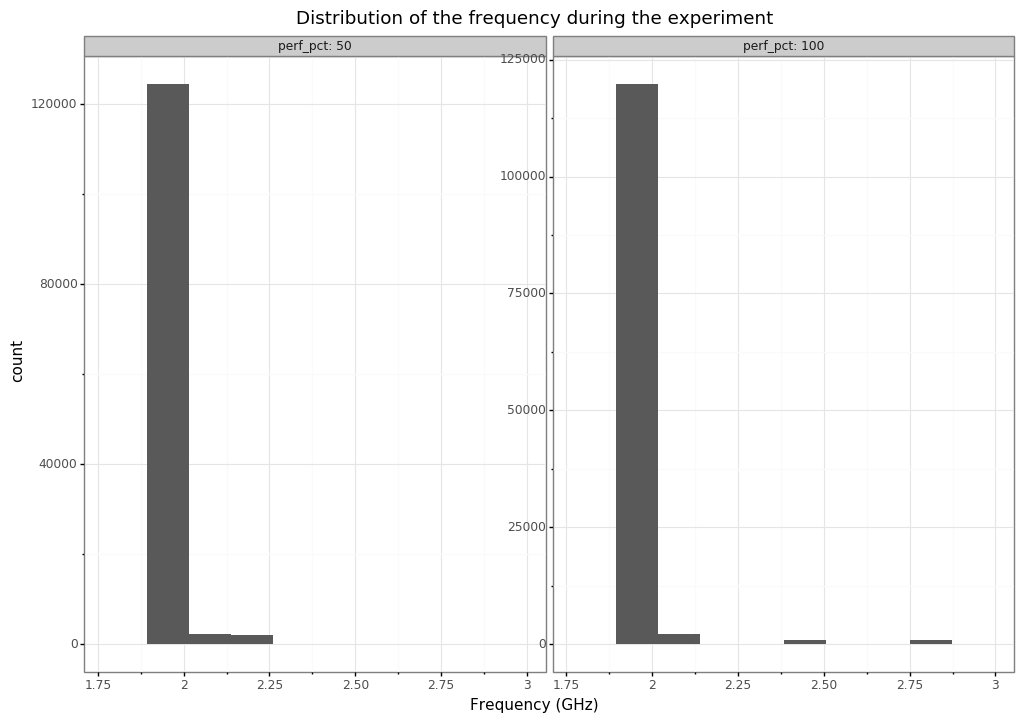

<ggplot: (-9223363305369099453)>


In [9]:
tmp = monitoring[(monitoring.in_exp) & (monitoring.kind == 'frequency')]
col = ['hyperthreading', 'turboboost', 'idle_state', 'perf_pct']
for c in col:
    print(ggplot(tmp)
            + aes(x='value')
            + geom_histogram(bins=10)
            + theme_bw()
            + labs(x='Frequency (GHz)')
            + ggtitle(f'Distribution of the frequency during the experiment')
            + facet_wrap(c, labeller='label_both', scales='free')
    #        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
            + expand_limits(x=[1.8, 2.9])
    )

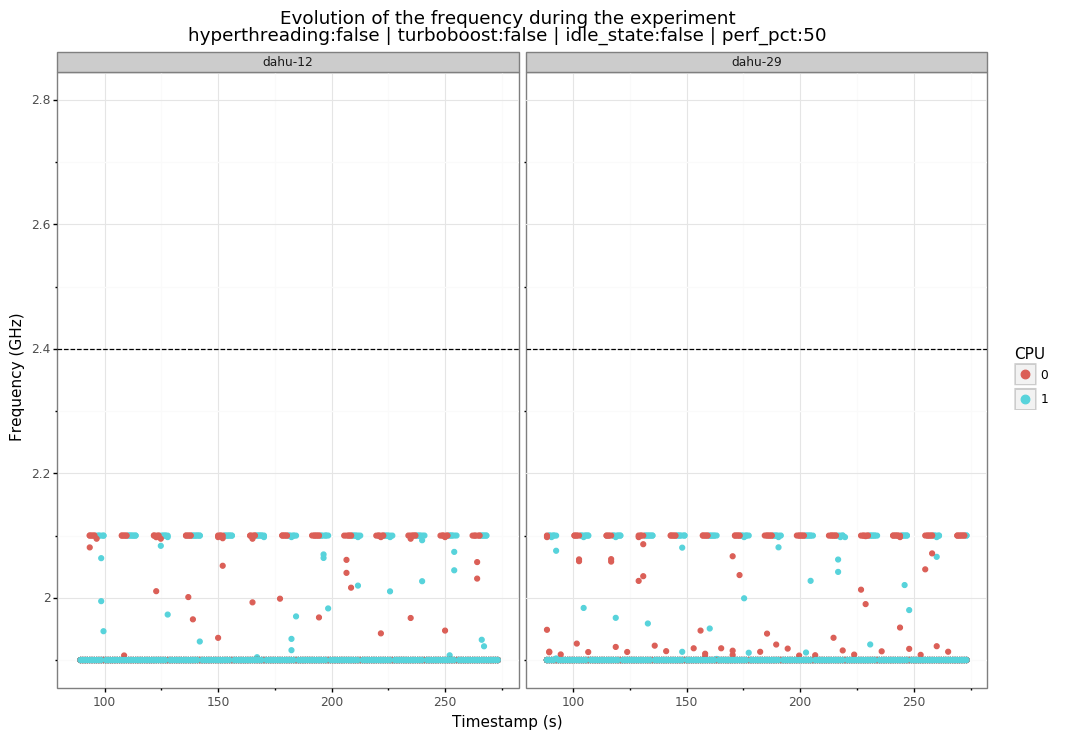

<ggplot: (-9223363305377608497)>


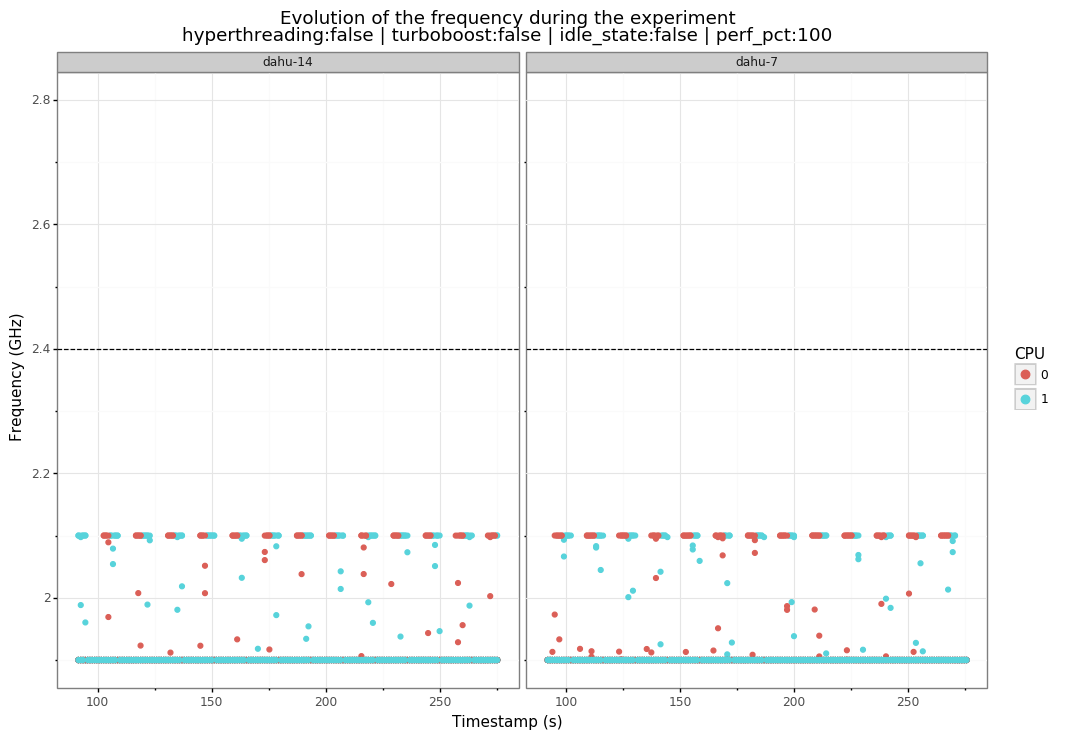

<ggplot: (8731477082316)>


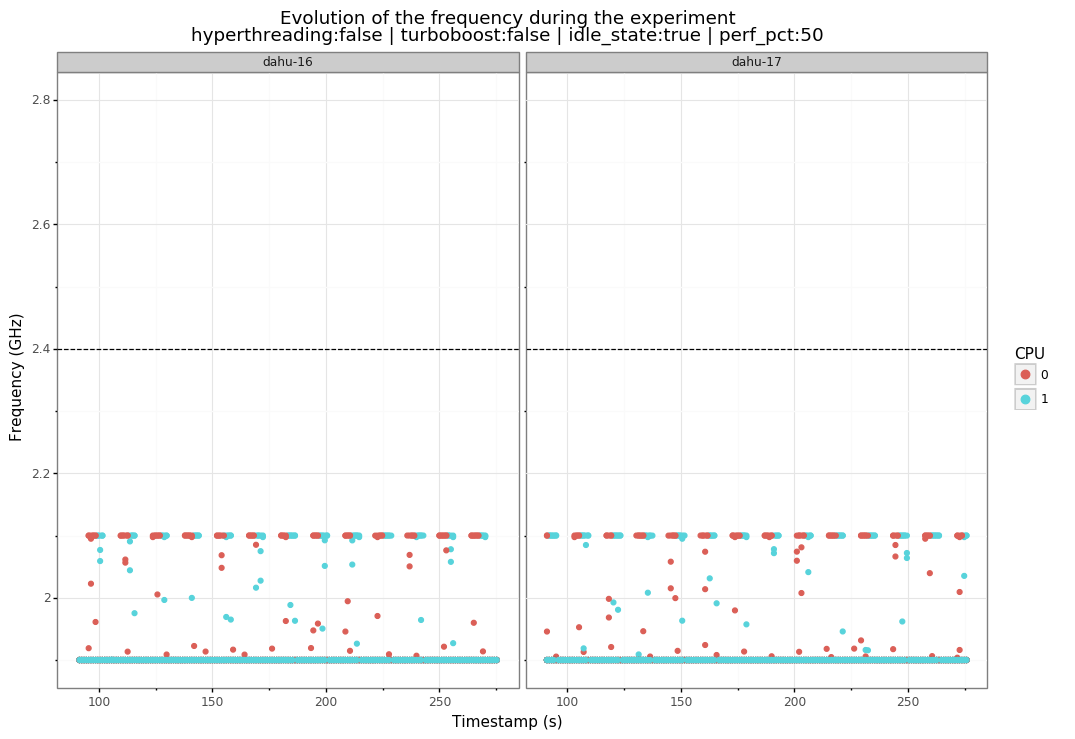

<ggplot: (-9223363305377894947)>


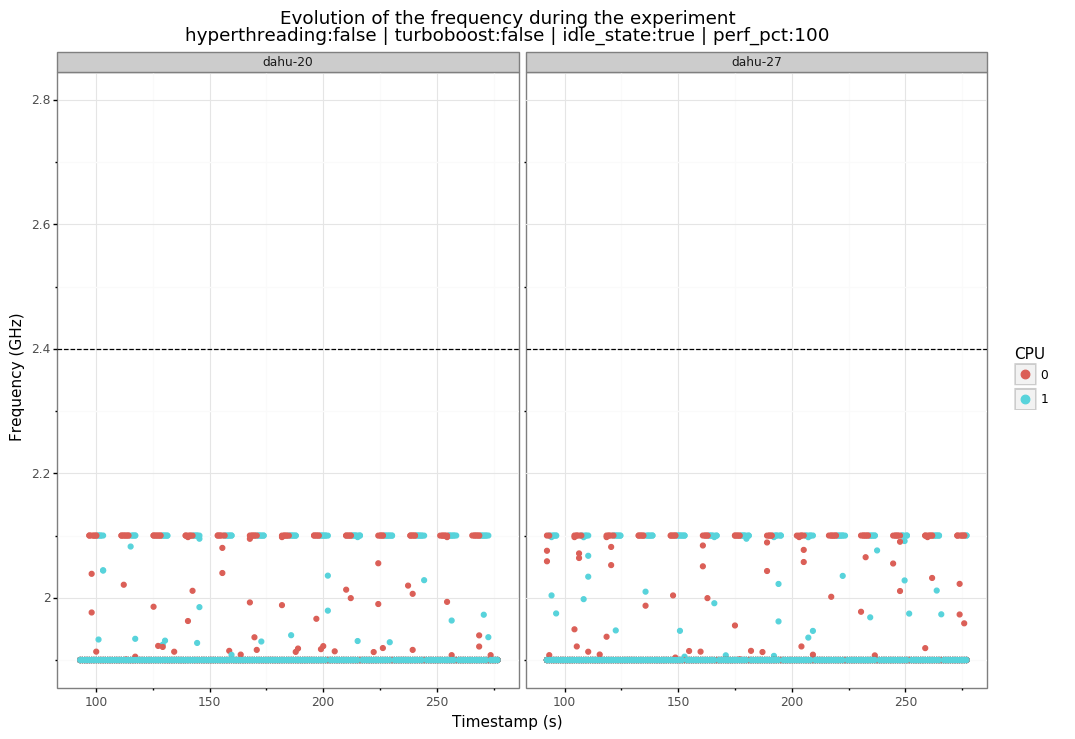

<ggplot: (8731476673358)>


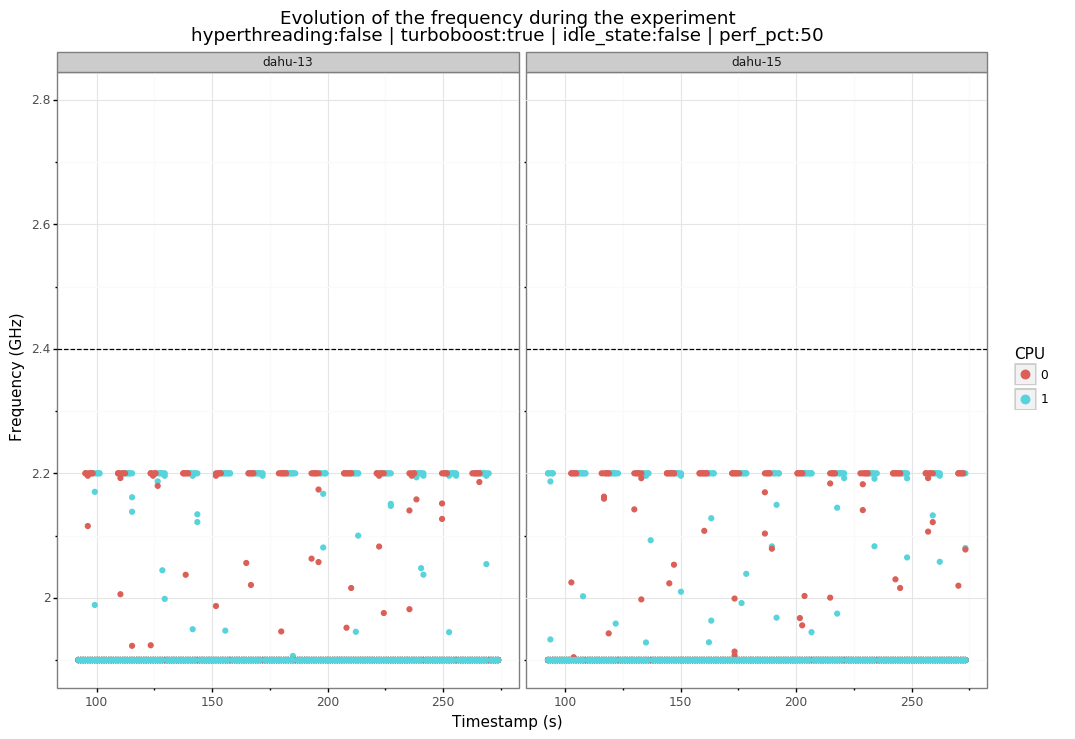

<ggplot: (8731476463999)>


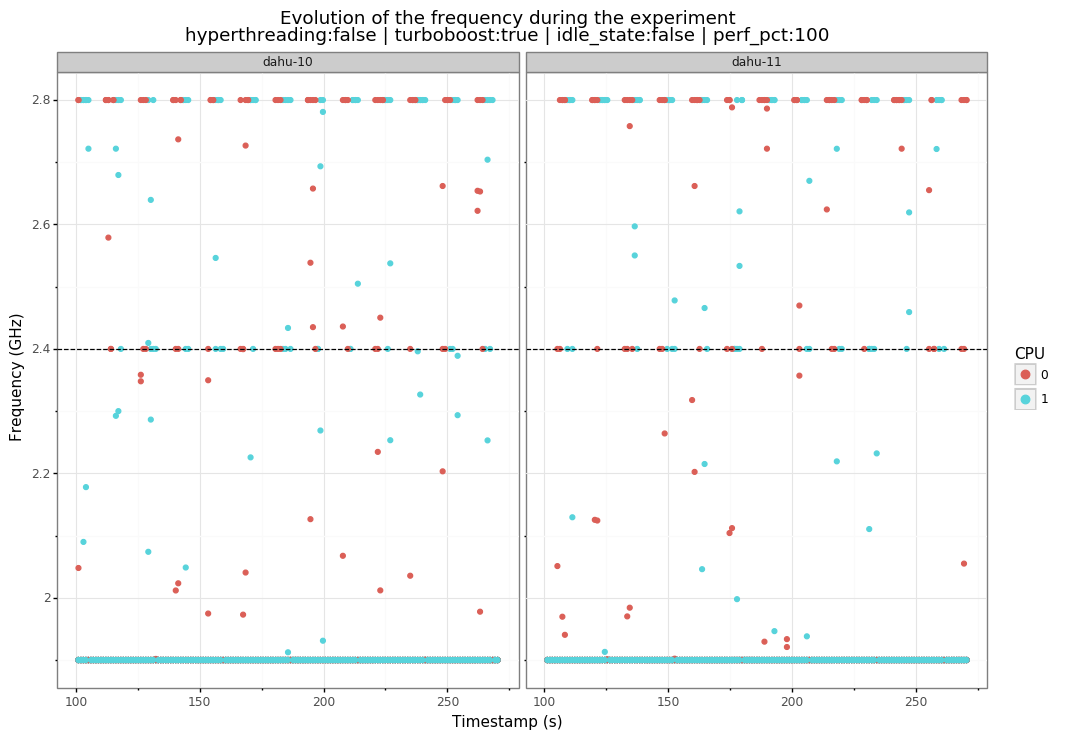

<ggplot: (-9223363305378011690)>


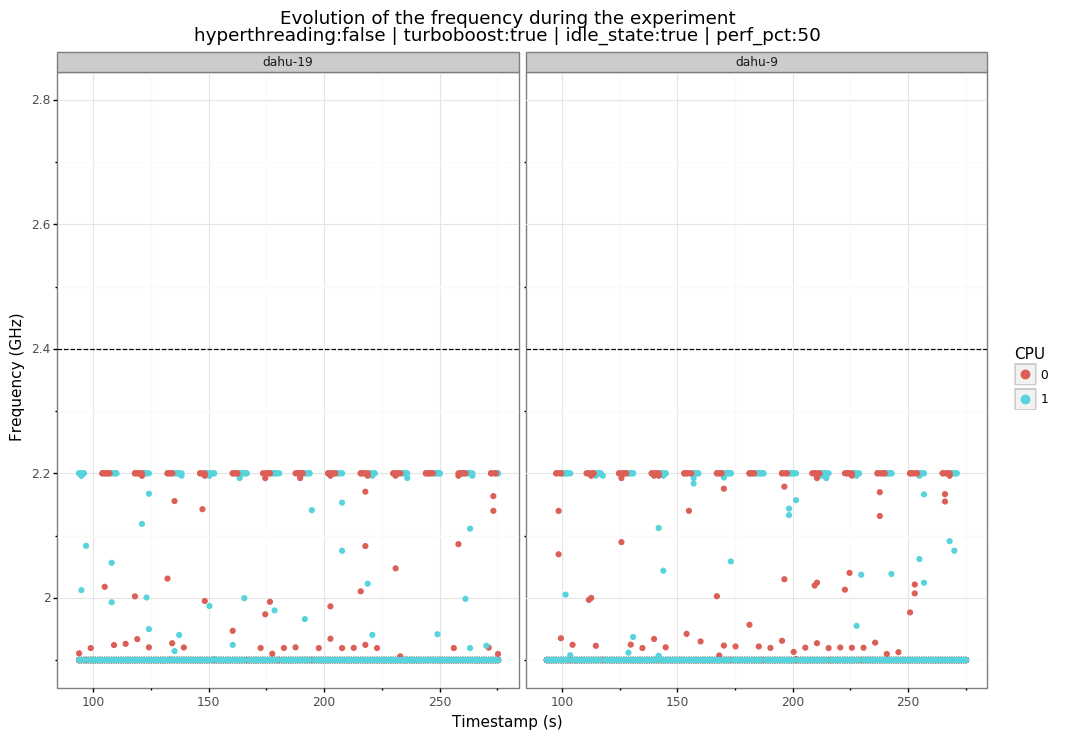

<ggplot: (-9223363305378327850)>


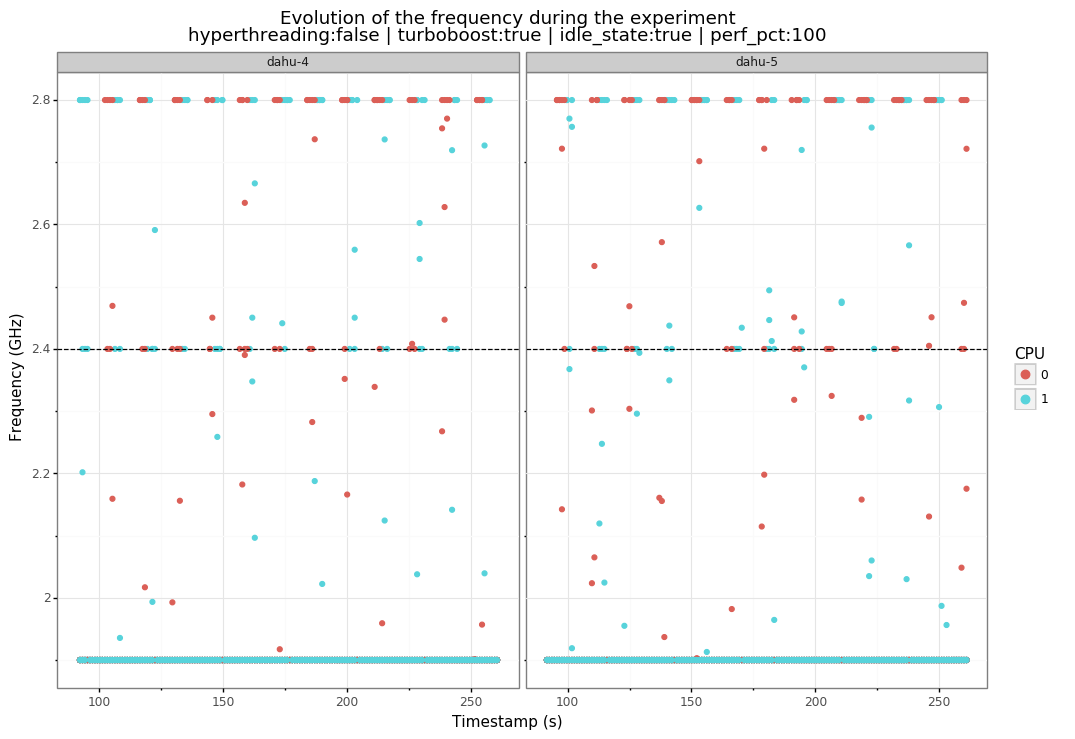

<ggplot: (8731476385491)>


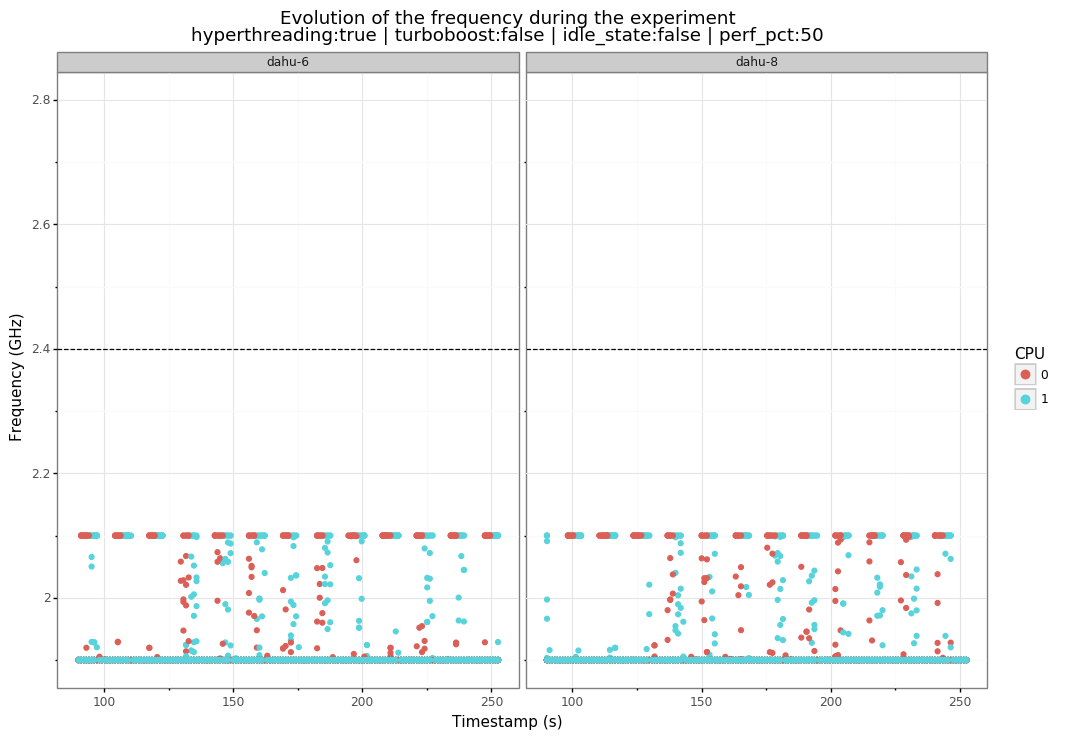

<ggplot: (8731476184566)>


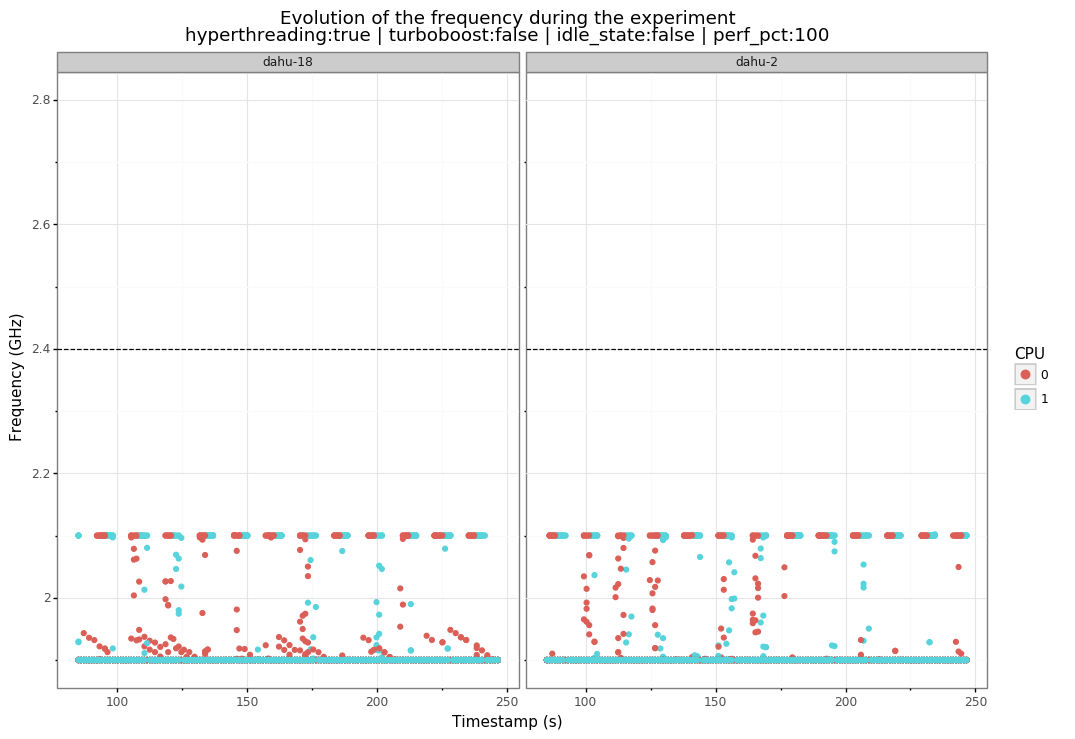

<ggplot: (8731476010104)>


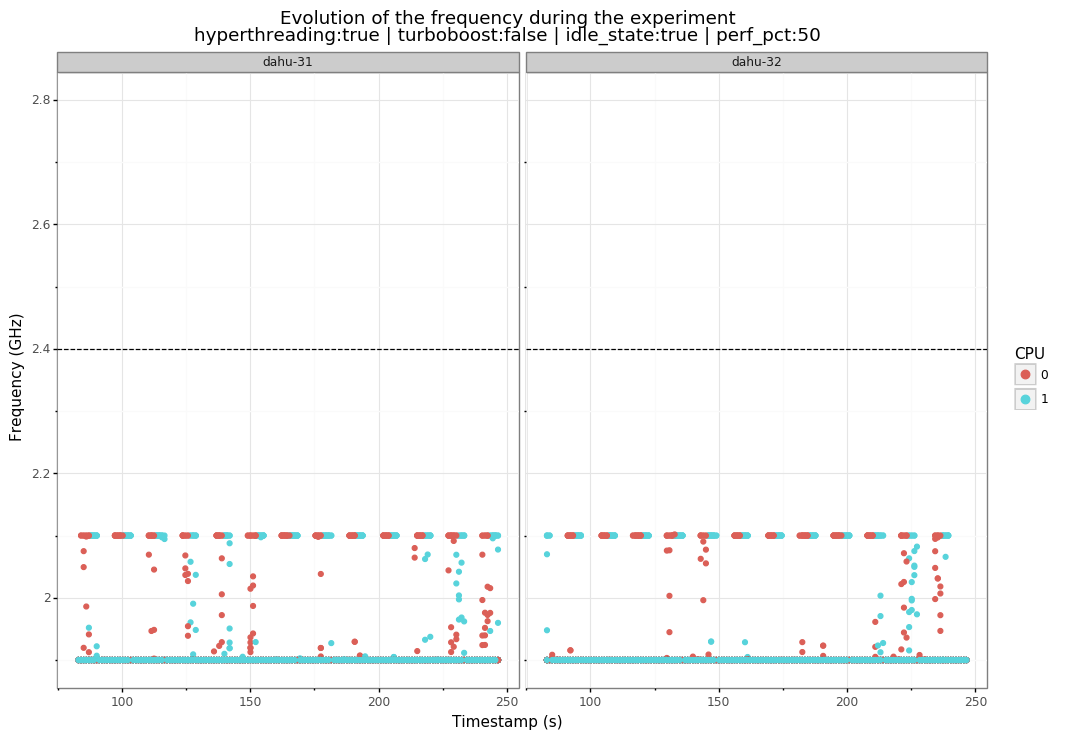

<ggplot: (8731469277942)>


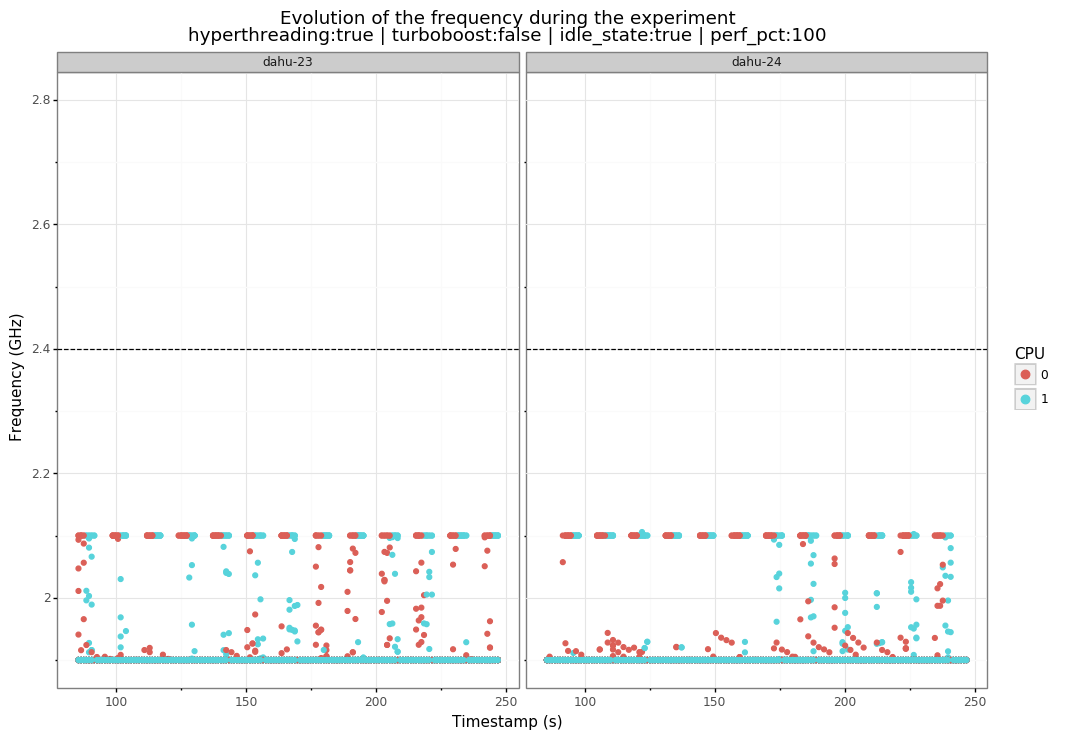

<ggplot: (8731476383752)>


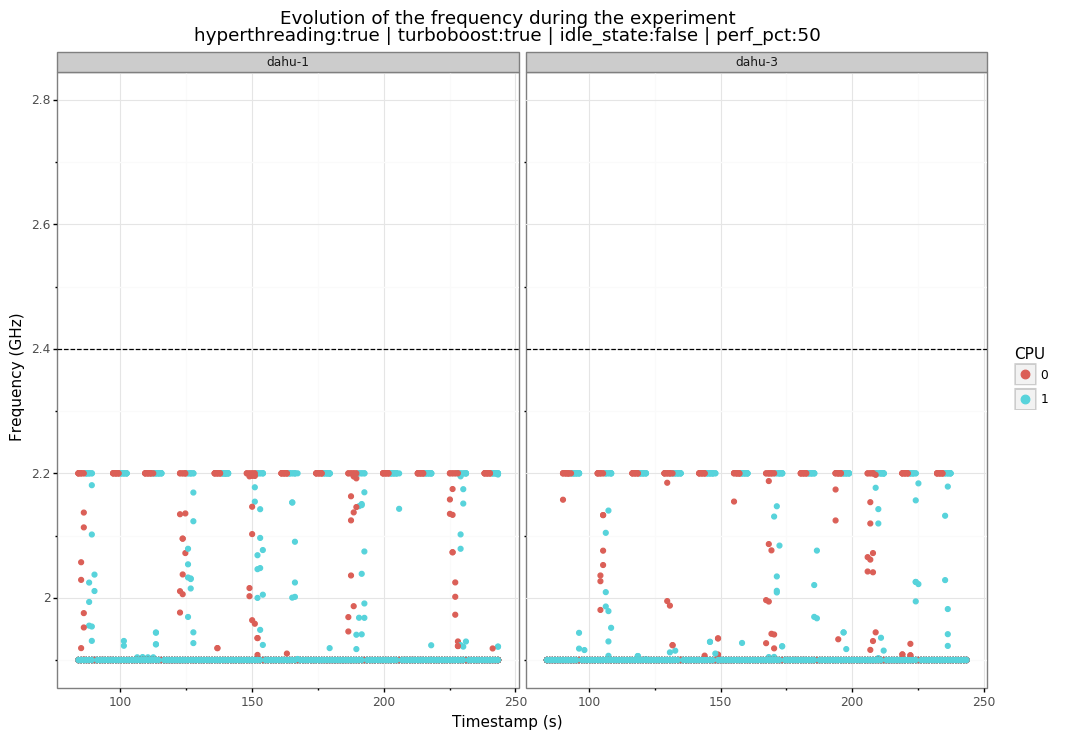

<ggplot: (8731477085893)>


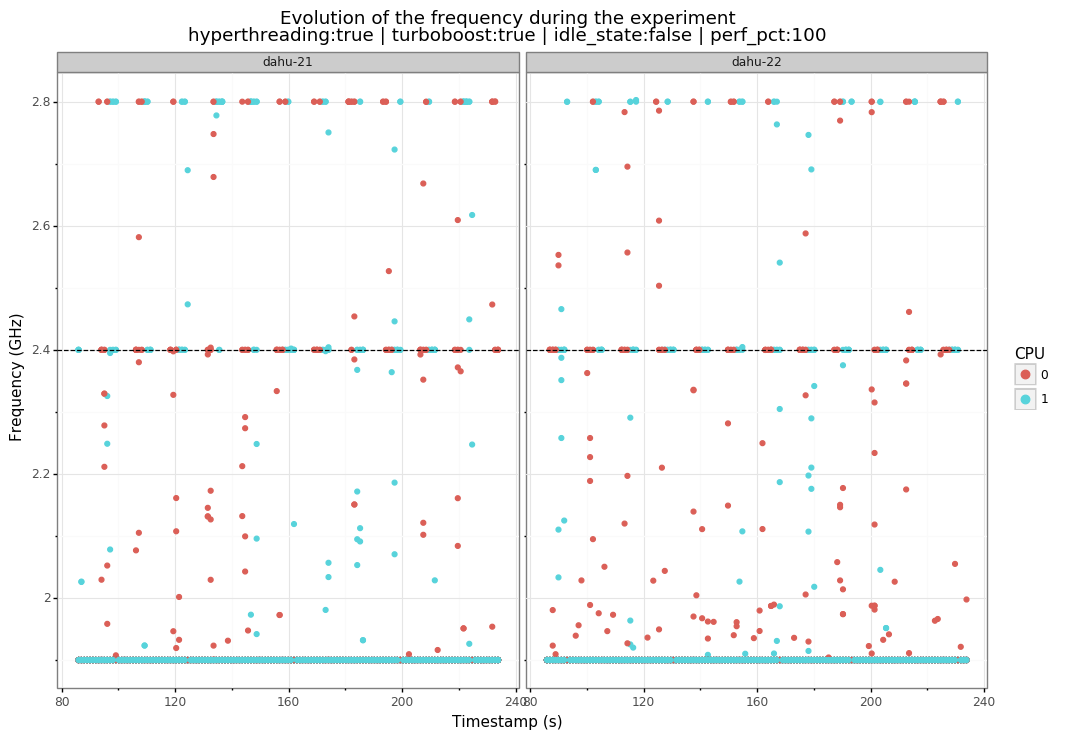

<ggplot: (8731476589779)>


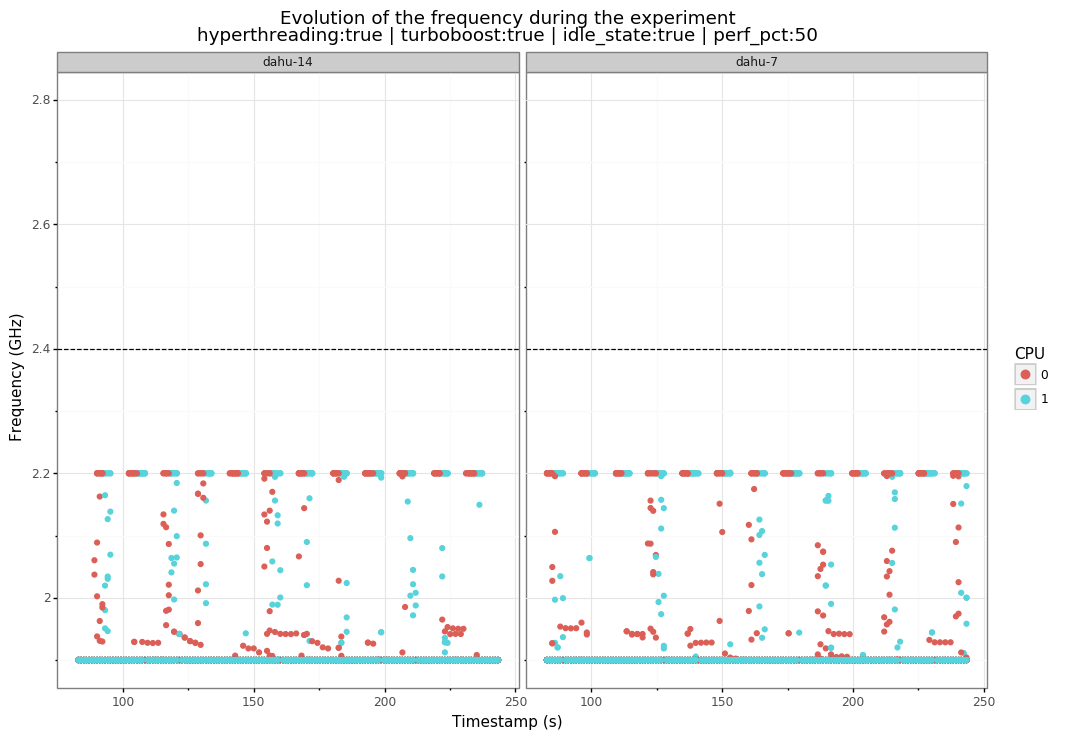

<ggplot: (8731477097974)>


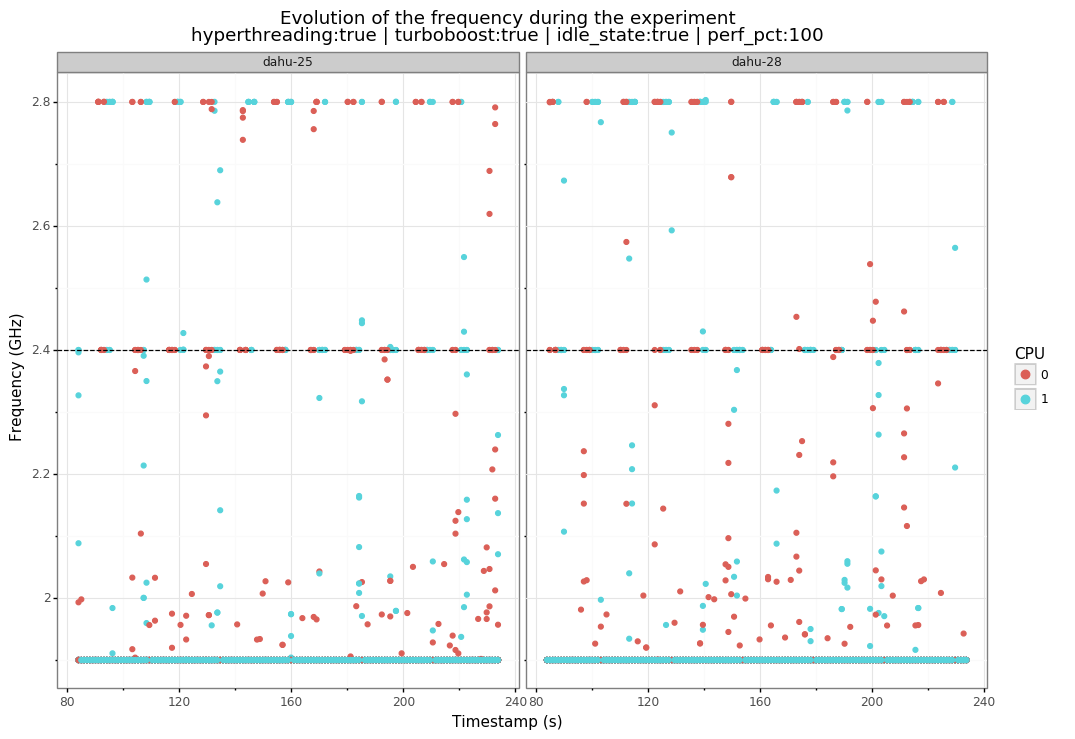

<ggplot: (-9223363305378691356)>


In [10]:
col = ['hyperthreading', 'turboboost', 'idle_state', 'perf_pct']
for _, (hyperthreading, turboboost, idle_state, perf_pct) in monitoring[col].drop_duplicates().sort_values(by=col).iterrows():
    tmp = monitoring[(monitoring.in_exp)
                     & (monitoring['kind'] == 'frequency')
                     & (monitoring['hyperthreading'] == hyperthreading)
                     & (monitoring['turboboost'] == turboboost)
                     & (monitoring['idle_state'] == idle_state)
                     & (monitoring['perf_pct'] == perf_pct)                     
                    ]
    title = f'Evolution of the frequency during the experiment\n'
    title += f'hyperthreading:{hyperthreading} | turboboost:{turboboost} | idle_state:{idle_state} | perf_pct:{perf_pct}'
    print(ggplot(tmp)
            + aes(x='timestamp', y='value', color='factor(cpu)')
            + geom_point()
            + theme_bw()
            + labs(x='Timestamp (s)', y='Frequency (GHz)', color='CPU')
            + ggtitle(title)
            + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
            + expand_limits(y=[1.9, 2.8])
            + facet_wrap('hostname')
            + geom_hline(yintercept=2.4, linetype='dashed')
        )